# DESCRIPTION

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

# Data Description

    * application_{train|test}.csv
        This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
        Static data for all applications. One row represents one loan in our data sample.

    * bureau.csv
        All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
        For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

    * bureau_balance.csv
        Monthly balances of previous credits in Credit Bureau.
        This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

    * POS_CASH_balance.csv
        Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
        This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

    * credit_card_balance.csv
        Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
        This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

    * previous_application.csv
        All previous applications for Home Credit loans of clients who have loans in our sample.
        There is one row for each previous application related to loans in our data sample.

    * installments_payments.csv
        Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
        There is a) one row for every payment that was made plus b) one row each for missed payment.
        One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

    * HomeCredit_columns_description.csv
        This file contains descriptions for the columns in the various data files.


# Libraries

In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

# Helper Functions

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [3]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:100].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(15, 20))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [4]:
print('\n'.join([''.join([(' I_Love_Data_Science_'[(x-y) % len('I_Love_Data_Science_')] if ((x*0.05)**2+(y*0.1)**2-1)**3-(x*0.05)**2*(y*0.1)**3 <= 0 else ' ') for x in range(-30, 30)]) for y in range(15, -15, -1)]))

                                                            
                                                            
                                                            
                cience I_           cience I_               
            a_Science I_Love_   a_Science I_Love_           
          ta_Science I_Love_Data_Science I_Love_Dat         
         ta_Science I_Love_Data_Science I_Love_Data_        
        ta_Science I_Love_Data_Science I_Love_Data_Sc       
        a_Science I_Love_Data_Science I_Love_Data_Sci       
        _Science I_Love_Data_Science I_Love_Data_Scie       
        Science I_Love_Data_Science I_Love_Data_Scien       
        cience I_Love_Data_Science I_Love_Data_Scienc       
        ience I_Love_Data_Science I_Love_Data_Science       
         nce I_Love_Data_Science I_Love_Data_Science        
          e I_Love_Data_Science I_Love_Data_Science         
           I_Love_Data_Science I_Love_Data_Science          
            Love_Data_Sc

# application_train

In [5]:
def application_train():

    df = pd.read_csv('../input/home-credit-default-risk/application_train.csv')
    test_df = pd.read_csv('../input/home-credit-default-risk/application_test.csv')

    df = df.append(test_df).reset_index()
    df = df[df['CODE_GENDER'] != 'XNA']

    lbe = LabelEncoder()

    for col in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
            df[col] = lbe.fit_transform(df[col])

    df = pd.get_dummies(df, dummy_na = True)

    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace = True)
    df['NEW_DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['NEW_INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['NEW_INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['NEW_ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['NEW_PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

    df.drop("index", axis = 1, inplace =  True)

    df.columns = pd.Index(["APP_" + col for col in df.columns.tolist()])

    df.rename(columns={"APP_SK_ID_CURR":"SK_ID_CURR"}, inplace = True)

    df.rename(columns={"APP_TARGET":"TARGET"}, inplace = True)
    
    return df

# bureau & bureau_balance

In [6]:
def bureau_bb():

    #bureau_balance tablosunun okutulması

    bb = pd.read_csv('../input/home-credit-default-risk/bureau_balance.csv')
    bb = pd.get_dummies(bb, dummy_na = True)

    agg_list = {"MONTHS_BALANCE":"count",
                "STATUS_0":["sum","mean"],
                "STATUS_1":["sum"],
                "STATUS_2":["sum"],
                "STATUS_3":["sum"],
                "STATUS_4":["sum"],
                "STATUS_5":["sum"],
                "STATUS_C":["sum","mean"],
                "STATUS_X":["sum","mean"] }

    bb_agg = bb.groupby("SK_ID_BUREAU").agg(agg_list)

    # Degisken isimlerinin yeniden adlandirilmasi 
    bb_agg.columns = pd.Index([col[0] + "_" + col[1].upper() for col in bb_agg.columns.tolist()])

    # Status_sum ile ilgili yeni bir degisken olusturma
    bb_agg['NEW_STATUS_SCORE'] = bb_agg['STATUS_1_SUM'] + bb_agg['STATUS_2_SUM']^2 + bb_agg['STATUS_3_SUM']^3 + bb_agg['STATUS_4_SUM']^4 + bb_agg['STATUS_5_SUM']^5

    bb_agg.drop(['STATUS_1_SUM','STATUS_2_SUM','STATUS_3_SUM','STATUS_4_SUM','STATUS_5_SUM'], axis=1,inplace=True)

    bureau = pd.read_csv('../input/home-credit-default-risk/bureau.csv')
    bureau_and_bb = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')

    #BUREAU BALANCE VE BUREAU ORTAK TABLO

    #CREDIT_TYPE degiskeninin sinif sayisini 3'e düsürmek 
    bureau_and_bb['CREDIT_TYPE'] = bureau_and_bb['CREDIT_TYPE'].replace(['Car loan',
              'Mortgage',
              'Microloan',
              'Loan for business development', 
              'Another type of loan',
              'Unknown type of loan', 
              'Loan for working capital replenishment',
              "Loan for purchase of shares (margin lending)",                                                
              'Cash loan (non-earmarked)', 
              'Real estate loan',
              "Loan for the purchase of equipment", 
              "Interbank credit", 
              "Mobile operator loan"], 'Rare')


    #CREDIT_ACTIVE degiskeninin sinif sayisini 2'ye düsürmek (Sold' u Closed a dahil etmek daha mi uygun olur ???)
    bureau_and_bb['CREDIT_ACTIVE'] = bureau_and_bb['CREDIT_ACTIVE'].replace(['Bad debt','Sold'], 'Active')

    # bureau_bb tablosundaki kategorik degiskenlere One Hot Encoding uygulanmasi
    bureau_and_bb = pd.get_dummies(bureau_and_bb, columns = ["CREDIT_TYPE","CREDIT_ACTIVE"])

    # CREDIT_CURRENCY degiskeninin %99u currency1, bu sebeple ayirt ediciligi olmayacagini dusundugumuz icin sildik  
    bureau_and_bb.drop(["SK_ID_BUREAU","CREDIT_CURRENCY"], inplace = True, axis = 1)


    #NEW FEATURES

    #ortalama kac aylık kredi aldıgını gösteren yeni degisken
    bureau_and_bb["NEW_MONTHS_CREDIT"]= round((bureau_and_bb.DAYS_CREDIT_ENDDATE - bureau_and_bb.DAYS_CREDIT)/30)

    agg_list = {
          "SK_ID_CURR":["count"],
          "DAYS_CREDIT":["min","max"],
          "CREDIT_DAY_OVERDUE":["sum","mean","max"],     
          "DAYS_CREDIT_ENDDATE":["max","min"],
          "DAYS_ENDDATE_FACT":["max","min"],
          "AMT_CREDIT_MAX_OVERDUE":["mean","max","min"],
          "CNT_CREDIT_PROLONG":["sum","mean","max","min"],
          "AMT_CREDIT_SUM":["mean","max","min"],            
          "AMT_CREDIT_SUM_DEBT":["sum","mean","max"],
          "AMT_CREDIT_SUM_LIMIT":["sum","mean","max"],
          'AMT_CREDIT_SUM_OVERDUE':["sum","mean","max"], 
          'DAYS_CREDIT_UPDATE':["max","min"],
          'AMT_ANNUITY':["sum","mean"],
          'MONTHS_BALANCE_COUNT':["sum"], 
          'STATUS_0_SUM':["sum"],         
          'STATUS_0_MEAN':["mean"], 
          'STATUS_C_SUM':["sum"], 
          'STATUS_C_MEAN':["mean"],
          'CREDIT_ACTIVE_Active':["sum","mean"], 
          'CREDIT_ACTIVE_Closed':["sum","mean"], 
          'CREDIT_TYPE_Rare':["sum","mean"],      
          'CREDIT_TYPE_Consumer credit':["sum","mean"], 
          'CREDIT_TYPE_Credit card':["sum","mean"],
          "NEW_MONTHS_CREDIT":["count","sum","mean","max","min"]}


    # bureau_bb_agg tablosuna aggreagation islemlerinin uygulanamasi  
    bureau_and_bb_agg = bureau_and_bb.groupby("SK_ID_CURR").agg(agg_list).reset_index()


    # Degisken isimlerinin yeniden adlandirilmasi 
    bureau_and_bb_agg.columns = pd.Index(["BB_" + col[0] + "_" + col[1].upper() for col in bureau_and_bb_agg.columns.tolist()])

    # kisinin aldıgı en yuksek ve en dusuk kredinin farkını gösteren yeni degisken
    bureau_and_bb_agg["BB_NEW_AMT_CREDIT_SUM_RANGE"] = bureau_and_bb_agg["BB_AMT_CREDIT_SUM_MAX"] - bureau_and_bb_agg["BB_AMT_CREDIT_SUM_MIN"]

    # ortalama kac ayda bir kredi cektigini ifade eden  yeni degisken
    bureau_and_bb_agg["BB_NEW_DAYS_CREDIT_RANGE"]= round((bureau_and_bb_agg["BB_DAYS_CREDIT_MAX"] - bureau_and_bb_agg["BB_DAYS_CREDIT_MIN"])/(30 * bureau_and_bb_agg["BB_SK_ID_CURR_COUNT"]))


    # Bureau: Active credits - using only numerical aggregations
    agg_list = {
            'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
            'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
            'DAYS_CREDIT_UPDATE': ['mean'],
            'CREDIT_DAY_OVERDUE': ['max', 'mean'],
            'AMT_CREDIT_MAX_OVERDUE': ['mean'],
            'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
            'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
            'AMT_CREDIT_SUM_OVERDUE': ['mean'],
            'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
            'AMT_ANNUITY': ['max', 'mean'],
            'CNT_CREDIT_PROLONG': ['sum']
        }


    active = bureau_and_bb[bureau_and_bb['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(agg_list)
    active_agg.columns = pd.Index(['BB_NEW_ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_and_bb_agg.rename(columns = {'BB_SK_ID_CURR_': 'SK_ID_CURR'}, inplace = True)
    bureau_and_bb_agg = bureau_and_bb_agg.join(active_agg, how='left', on='SK_ID_CURR')

    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau_and_bb[bureau_and_bb['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(agg_list)
    closed_agg.columns = pd.Index(['BB_NEW_CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_and_bb_agg = bureau_and_bb_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    
    return bureau_and_bb_agg

# installments_payments

In [7]:
def installments_payments():

    #Read the installments_payments.csv
    ins = pd.read_csv('../input/home-credit-default-risk/installments_payments.csv')

    ins['NEW_DAYS_PAID_EARLIER'] = ins['DAYS_INSTALMENT']-ins['DAYS_ENTRY_PAYMENT']

    # Her bir taksit ödemesinin gec olup olmama durumu 1: gec ödedi 0: erken ödemeyi temsil eder
    ins['NEW_NUM_PAID_LATER'] = ins['NEW_DAYS_PAID_EARLIER'].map(lambda x: 1 if x<0 else 0)

    # Agrregation ve degisken tekillestirme
    agg_list = {'NUM_INSTALMENT_VERSION':['nunique'],
               'NUM_INSTALMENT_NUMBER':'max',
               'DAYS_INSTALMENT':['min','max'],
               'DAYS_ENTRY_PAYMENT':['min','max'],
               'AMT_INSTALMENT':['min','max','sum','mean'],
               'AMT_PAYMENT':['min','max','sum','mean'],
               'NEW_DAYS_PAID_EARLIER':'mean',
               'NEW_NUM_PAID_LATER':'sum'}


    ins_agg = ins.groupby('SK_ID_PREV').agg(agg_list)


    # Multi index problemi cözümü
    ins_agg.columns = pd.Index(["INS_" + e[0] + '_' + e[1].upper() for e in ins_agg.columns.tolist()])

    # drop variables 
    ins_agg.drop(['INS_DAYS_INSTALMENT_MIN',
                   'INS_DAYS_INSTALMENT_MAX',
                   'INS_DAYS_ENTRY_PAYMENT_MIN',
                   'INS_DAYS_ENTRY_PAYMENT_MAX'],axis=1,inplace=True)

    # Kredi ödeme yüzdesi ve toplam kalan borc
    ins_agg['INS_NEW_PAYMENT_PERC'] = ins_agg['INS_AMT_PAYMENT_SUM'] / ins_agg['INS_AMT_INSTALMENT_SUM']
    ins_agg['INS_NEW_PAYMENT_DIFF'] = ins_agg['INS_AMT_INSTALMENT_SUM'] - ins_agg['INS_AMT_PAYMENT_SUM']
    
    agg_list_previous_application = {}
    
    for col in ins_agg.columns:
        agg_list_previous_application[col] = ['mean',"min","max","sum"]
    
    ins_agg.reset_index(inplace = True) 
    
    return agg_list_previous_application, ins_agg

# pos_cash_balance

In [8]:
def pos_cash_balance(agg_list_previous_application):

    pos = pd.read_csv('../input/home-credit-default-risk/POS_CASH_balance.csv')
    # Kategorik Degiskenimizi Dummy Degiskenine Dönüstürme
    pos = pd.get_dummies(pos, columns=['NAME_CONTRACT_STATUS'], dummy_na = True)
    # Aggregation Islemi - Tekillestirme
    agg_list = {'MONTHS_BALANCE':['min','max'],
                                            'CNT_INSTALMENT':['min','max'],
                                            'CNT_INSTALMENT_FUTURE':['min','max'],
                                            'SK_DPD':['max','mean'],
                                            'SK_DPD_DEF':['max','mean'],
                                            'NAME_CONTRACT_STATUS_Active':'sum',
                                            'NAME_CONTRACT_STATUS_Amortized debt':'sum',
                                            'NAME_CONTRACT_STATUS_Approved':'sum',
                                            'NAME_CONTRACT_STATUS_Canceled':'sum',
                                            'NAME_CONTRACT_STATUS_Completed':'sum',
                                            'NAME_CONTRACT_STATUS_Demand':'sum',
                                            'NAME_CONTRACT_STATUS_Returned to the store':'sum',
                                            'NAME_CONTRACT_STATUS_Signed':'sum',
                                            'NAME_CONTRACT_STATUS_XNA':'sum',
                                            'NAME_CONTRACT_STATUS_nan':'sum'
                                          }

    pos_agg = pos.groupby('SK_ID_PREV').agg(agg_list)

    # Multilayer index'i tek boyutlu index'e dönüstürme
    pos_agg.columns= pd.Index(["POS_" + e[0] + '_' + e[1].upper() for e in pos_agg.columns.tolist()])

    # SK_DPD kac kredide 0 olma durumu (SK_DPD MAX alacagiz 0 durumunu veriyor) 
    # SK_DPD_DEF (SK_DPD_DEF_MAX sifir olma durumunu veriyor)
    # CNT_INSTALMENT_FUTURE_MIN==0 oldugunda NAME_CONTRACT_STATUS_Completed_SUM==0 olma durumu 

    pos_agg['POS_NEW_IS_CREDIT_NOT_COMPLETED_ON_TIME']= (pos_agg['POS_CNT_INSTALMENT_FUTURE_MIN']==0) & (pos_agg['POS_NAME_CONTRACT_STATUS_Completed_SUM']==0)


    # 1:kredi zamaninda kapanmamis 0:kredi zamaninda kapanmis

    pos_agg['POS_NEW_IS_CREDIT_NOT_COMPLETED_ON_TIME']=pos_agg['POS_NEW_IS_CREDIT_NOT_COMPLETED_ON_TIME'].astype(int)

    pos_agg.drop(['POS_NAME_CONTRACT_STATUS_Approved_SUM',
                   'POS_NAME_CONTRACT_STATUS_Amortized debt_SUM',
                   'POS_NAME_CONTRACT_STATUS_Canceled_SUM',
                   'POS_NAME_CONTRACT_STATUS_Returned to the store_SUM',
                   'POS_NAME_CONTRACT_STATUS_Signed_SUM',
                   'POS_NAME_CONTRACT_STATUS_XNA_SUM',
                   'POS_NAME_CONTRACT_STATUS_nan_SUM'],axis=1,inplace=True)

    for col in pos_agg.columns:
        agg_list_previous_application[col] = ['mean',"min","max","sum"]

    pos_agg.reset_index(inplace = True)     
    
    return agg_list_previous_application, pos_agg

# credit_card_balance

In [9]:
def credit_card_balance():

    CCB = pd.read_csv('../input/home-credit-default-risk/credit_card_balance.csv')

    CCB = pd.get_dummies(CCB, columns= ['NAME_CONTRACT_STATUS'] )  # artik tumu sayisal 

    dropthis = ['NAME_CONTRACT_STATUS_Approved', 'NAME_CONTRACT_STATUS_Demand',
           'NAME_CONTRACT_STATUS_Refused', 'NAME_CONTRACT_STATUS_Sent proposal',
           'NAME_CONTRACT_STATUS_Signed' ]

    CCB = CCB.drop(dropthis, axis=1)

    grp = CCB.groupby(by = ['SK_ID_CURR'])['SK_ID_PREV'].nunique().reset_index().rename(index = str, columns = {'SK_ID_PREV': 'NUMBER_OF_LOANS_PER_CUSTOMER'})
    CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')

    grp = CCB.groupby(by = ['SK_ID_CURR', 'SK_ID_PREV'])['CNT_INSTALMENT_MATURE_CUM'].max().reset_index().rename(index = str, columns = {'CNT_INSTALMENT_MATURE_CUM': 'NUMBER_OF_INSTALMENTS'})
    grp1 = grp.groupby(by = ['SK_ID_CURR'])['NUMBER_OF_INSTALMENTS'].sum().reset_index().rename(index = str, columns = {'NUMBER_OF_INSTALMENTS': 'TOTAL_INSTALMENTS_OF_ALL_LOANS'})
    CCB = CCB.merge(grp1, on = ['SK_ID_CURR'], how = 'left')

    CCB['INSTALLMENTS_PER_LOAN'] = (CCB['TOTAL_INSTALMENTS_OF_ALL_LOANS']/CCB['NUMBER_OF_LOANS_PER_CUSTOMER']).astype('uint32')


    # Bu fonksiyon, kac defa odemelerin geciktigini hesaplar   # Function to calculate number of times Days Past Due occurred 
    def geciken_gun_hesapla(DPD):

        # DPD ile beklenen bir seri: SK_DPD degiskeninin her bir prev_app daki gecmis kredi icin olan degerleri  # DPD is a series of values of SK_DPD for each of the groupby combination 
        # We convert it to a list to get the number of SK_DPD values NOT EQUALS ZERO
        x = DPD.tolist()
        c = 0
        for i,j in enumerate(x):
            if j != 0:
                c += 1  
        return c 

    grp = CCB.groupby(by = ['SK_ID_CURR', 'SK_ID_PREV']).apply(lambda x: geciken_gun_hesapla(x.SK_DPD)).reset_index().rename(index = str, columns = {0: 'NUMBER_OF_DPD'})
    grp1 = grp.groupby(by = ['SK_ID_CURR'])['NUMBER_OF_DPD'].mean().reset_index().rename(index = str, columns = {'NUMBER_OF_DPD' : 'DPD_COUNT'})

    CCB = CCB.merge(grp1, on = ['SK_ID_CURR'], how = 'left')


    def f(min_pay, total_pay):

        M = min_pay.tolist()
        T = total_pay.tolist()
        P = len(M)        # P: taksit sayisi
        c = 0 
        # Find the count of transactions when Payment made is less than Minimum Payment 
        for i in range(len(M)):
            if T[i] < M[i]:
                c += 1  
        return (100*c)/P

    grp = CCB.groupby(by = ['SK_ID_CURR']).apply(lambda x: f(x.AMT_INST_MIN_REGULARITY, x.AMT_PAYMENT_CURRENT)).reset_index().rename(index = str, columns = { 0 : 'PERCENTAGE_MIN_MISSED_PAYMENTS'})
    CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')

    grp = CCB.groupby(by = ['SK_ID_CURR'])['AMT_DRAWINGS_ATM_CURRENT'].sum().reset_index().rename(index = str, columns = {'AMT_DRAWINGS_ATM_CURRENT' : 'DRAWINGS_ATM'})
    CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')


    grp = CCB.groupby(by = ['SK_ID_CURR'])['AMT_DRAWINGS_CURRENT'].sum().reset_index().rename(index = str, columns = {'AMT_DRAWINGS_CURRENT' : 'DRAWINGS_TOTAL'})
    CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')


    CCB['CASH_CARD_RATIO1'] = (CCB['DRAWINGS_ATM']/CCB['DRAWINGS_TOTAL'])*100  # ATM den cektigi nakit / toplam cektigi
    del CCB['DRAWINGS_ATM']
    del CCB['DRAWINGS_TOTAL']

    grp = CCB.groupby(by = ['SK_ID_CURR'])['CASH_CARD_RATIO1'].mean().reset_index().rename(index = str, columns ={ 'CASH_CARD_RATIO1' : 'CASH_CARD_RATIO'})
    CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')


    grp = CCB.groupby(by = ['SK_ID_CURR'])['AMT_DRAWINGS_CURRENT'].sum().reset_index().rename(index = str, columns = {'AMT_DRAWINGS_CURRENT' : 'TOTAL_DRAWINGS'})
    CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')


    grp = CCB.groupby(by = ['SK_ID_CURR'])['CNT_DRAWINGS_CURRENT'].sum().reset_index().rename(index = str, columns = {'CNT_DRAWINGS_CURRENT' : 'NUMBER_OF_DRAWINGS'})
    CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')


    CCB['DRAWINGS_RATIO1'] = (CCB['TOTAL_DRAWINGS']/CCB['NUMBER_OF_DRAWINGS'])*100     # yuzdelik degil, genisleme yapmis
    del CCB['TOTAL_DRAWINGS']
    del CCB['NUMBER_OF_DRAWINGS']


    grp = CCB.groupby(by = ['SK_ID_CURR'])['DRAWINGS_RATIO1'].mean().reset_index().rename(index = str, columns ={ 'DRAWINGS_RATIO1' : 'DRAWINGS_RATIO'})
    CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')

    del CCB['DRAWINGS_RATIO1']

    CCB['CC_COUNT'] = CCB.groupby('SK_ID_CURR').size()

    CCB_agg = CCB.groupby('SK_ID_CURR').agg({
        'MONTHS_BALANCE':["sum","mean"], 
        'AMT_BALANCE':["sum","mean","min","max"],
        'AMT_CREDIT_LIMIT_ACTUAL':["sum","mean"], 

        'AMT_DRAWINGS_ATM_CURRENT':["sum","mean","min","max"],
        'AMT_DRAWINGS_CURRENT':["sum","mean","min","max"], 
        'AMT_DRAWINGS_OTHER_CURRENT':["sum","mean","min","max"],
        'AMT_DRAWINGS_POS_CURRENT':["sum","mean","min","max"], 
        'AMT_INST_MIN_REGULARITY':["sum","mean","min","max"],
        'AMT_PAYMENT_CURRENT':["sum","mean","min","max"], 
        'AMT_PAYMENT_TOTAL_CURRENT':["sum","mean","min","max"],
        'AMT_RECEIVABLE_PRINCIPAL':["sum","mean","min","max"], 
        'AMT_RECIVABLE':["sum","mean","min","max"], 
        'AMT_TOTAL_RECEIVABLE':["sum","mean","min","max"],

        'CNT_DRAWINGS_ATM_CURRENT':["sum","mean"], 
        'CNT_DRAWINGS_CURRENT':["sum","mean","max"],
        'CNT_DRAWINGS_OTHER_CURRENT':["mean","max"], 
        'CNT_DRAWINGS_POS_CURRENT':["sum","mean","max"],
        'CNT_INSTALMENT_MATURE_CUM':["sum","mean","max","min"],    
        'SK_DPD':["sum","mean","max"], 
        'SK_DPD_DEF':["sum","mean","max"],

        'NAME_CONTRACT_STATUS_Active':["sum","mean","min","max"], 
        'INSTALLMENTS_PER_LOAN':["sum","mean","min","max"],

        'NUMBER_OF_LOANS_PER_CUSTOMER':["mean"], 
        'DPD_COUNT':["mean"],
        'PERCENTAGE_MIN_MISSED_PAYMENTS':["mean"], 
        'CASH_CARD_RATIO':["mean"], 
        'DRAWINGS_RATIO':["mean"]})


    CCB_agg.columns = pd.Index(['CCB_' + e[0] + "_" + e[1].upper() for e in CCB_agg.columns.tolist()])

    CCB_agg.reset_index(inplace = True)
    
    return CCB_agg

# previous_application

In [10]:
def previous_application(agg_list_previous_application):


    df_prev = pd.read_csv('../input/home-credit-default-risk/previous_application.csv')

    # "WEEKDAY_APPR_PROCESS_START"  değişkeninin  WEEK_DAY ve WEEKEND olarak iki kategoriye ayrılması

    df_prev["WEEKDAY_APPR_PROCESS_START"] = df_prev["WEEKDAY_APPR_PROCESS_START"].replace(['MONDAY','TUESDAY', 'WEDNESDAY','THURSDAY','FRIDAY'], 'WEEK_DAY')
    df_prev["WEEKDAY_APPR_PROCESS_START"] = df_prev["WEEKDAY_APPR_PROCESS_START"].replace(['SATURDAY', 'SUNDAY'], 'WEEKEND')

    # "HOUR_APPR_PROCESS_START"  değişkeninin working_hours ve off_hours olarak iki kategoriye ayrılması
    a = [8,9,10,11,12,13,14,15,16,17]
    df_prev["HOUR_APPR_PROCESS_START"] = df_prev["HOUR_APPR_PROCESS_START"].replace(a, 'working_hours')

    b = [18,19,20,21,22,23,0,1,2,3,4,5,6,7]
    df_prev["HOUR_APPR_PROCESS_START"] = df_prev["HOUR_APPR_PROCESS_START"].replace(b, 'off_hours')


    # DAYS_DECISION değeri 1 yıldan küçük olanlara 1, büyük olanlara 0 değeri verildi.
    df_prev["DAYS_DECISION"] = [1 if abs(i/(12*30)) <=1 else 0 for i in df_prev.DAYS_DECISION]

    # "NAME_TYPE_SUITE"  değişkeninin alone ve not_alone olarak iki kategoriye ayrılması

    df_prev["NAME_TYPE_SUITE"] = df_prev["NAME_TYPE_SUITE"].replace('Unaccompanied', 'alone')

    b = ['Family', 'Spouse, partner', 'Children', 'Other_B', 'Other_A', 'Group of people']
    df_prev["NAME_TYPE_SUITE"] = df_prev["NAME_TYPE_SUITE"].replace(b, 'not_alone')



    # "NAME_GOODS_CATEGORY"  değişkenindeki bu değerler others olarak kategorize edilecek
    a = ['Auto Accessories', 'Jewelry', 'Homewares', 'Medical Supplies', 'Vehicles', 'Sport and Leisure', 
         'Gardening', 'Other', 'Office Appliances', 'Tourism', 'Medicine', 'Direct Sales', 'Fitness', 'Additional Service', 
         'Education', 'Weapon', 'Insurance', 'House Construction', 'Animals'] 
    df_prev["NAME_GOODS_CATEGORY"] = df_prev["NAME_GOODS_CATEGORY"].replace(a, 'others')

    # "NAME_SELLER_INDUSTRY"  değişkenindeki bu değerler others olarak kategorize edilecek
    a = ['Auto technology', 'Jewelry', 'MLM partners', 'Tourism'] 
    df_prev["NAME_SELLER_INDUSTRY"] = df_prev["NAME_SELLER_INDUSTRY"].replace(a, 'others')
    # İstenilen krecinin verilen krediye oranı içeren değişkeni türetir
    df_prev["LOAN_RATE"] = df_prev.AMT_APPLICATION/df_prev.AMT_CREDIT

    #YENI DEGISKENLER

    # İstenilen krecinin verilen krediye oranı içeren değişkeni türetir
    df_prev["NEW_LOAN_RATE"] = df_prev.AMT_APPLICATION/df_prev.AMT_CREDIT

    # Ödeme gününü geciktirmiş mi bunu gösteren churn_prev değişkeni türetilir.
    # 1= geciktirmiş, 0 = geciktirmemiş, NaN = boş değer
    k = df_prev.DAYS_LAST_DUE_1ST_VERSION - df_prev.DAYS_LAST_DUE
    df_prev["NEW_CHURN_PREV"] = [1 if i >= 0 else (0 if i < 0  else "NaN") for i in k]


    # NFLAG_INSURED_ON_APPROVAL değişkeni yerine kullanılmak izere NEW_INSURANCE değişkeni tanımlandı.
    df_prev[(df_prev['AMT_CREDIT'] == 0) | (df_prev['AMT_GOODS_PRICE'] == 0)]['NEW_INSURANCE'] = np.nan
    df_prev['sigorta_miktari'] = df_prev['AMT_CREDIT'] - df_prev['AMT_GOODS_PRICE']
    df_prev["NEW_INSURANCE"] = df_prev['sigorta_miktari'].apply(lambda x: 1 if x > 0 else (0 if x <= 0 else np.nan))
    df_prev.drop('sigorta_miktari', axis=1, inplace=True)

    # INTEREST_RATE değişkenini oluşturur.
    #df_prev['INTEREST_RATE'] = (df_prev.AMT_ANNUITY*df_prev.CNT_PAYMENT/df_prev.AMT_CREDIT)**(12/df_prev.CNT_PAYMENT)-1
    #df_prev[df_prev['INTEREST_RATE']==-1]=np.nan


    drop_list = ['AMT_DOWN_PAYMENT', 'SELLERPLACE_AREA', 'CNT_PAYMENT', 'PRODUCT_COMBINATION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
                'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE','DAYS_TERMINATION','NFLAG_INSURED_ON_APPROVAL']
    df_prev.drop(drop_list, axis = 1, inplace = True)

    # Previous tablosundaki kategorik değişkenlerin isimlerini tutar.
    category_columns=[]
    for i in df_prev.columns:
        if df_prev[i].dtypes == "O":
            category_columns.append(i)

    df_prev = pd.get_dummies(df_prev, columns = category_columns )

    prev_agg_list = {"SK_ID_CURR":["count"], 
                "AMT_ANNUITY":["max"],
                "AMT_APPLICATION":["min","mean","max"],
                "AMT_CREDIT":["max"], 
                "AMT_GOODS_PRICE":["sum", "mean"],
                "NFLAG_LAST_APPL_IN_DAY":["sum","mean"], 
                "RATE_DOWN_PAYMENT":["sum", "mean"],
                "RATE_INTEREST_PRIMARY":["sum", "mean"],
                "RATE_INTEREST_PRIVILEGED":["sum", "mean"],
                "DAYS_DECISION":["sum"],
                "NEW_LOAN_RATE":["sum", "mean", "min", "max"],
                "NEW_INSURANCE":["sum", "mean"],
                #"INTEREST_RATE":["sum", "mean", "min", "max"],
                "NAME_CONTRACT_TYPE_Cash loans":["sum", "mean"],
                "NAME_CONTRACT_TYPE_Consumer loans":["sum", "mean"],
                "NAME_CONTRACT_TYPE_Revolving loans":["sum", "mean"],
                "NAME_CONTRACT_TYPE_XNA":["sum", "mean"],
                "WEEKDAY_APPR_PROCESS_START_WEEKEND":["sum", "mean"],
                "WEEKDAY_APPR_PROCESS_START_WEEK_DAY":["sum", "mean"],
                "HOUR_APPR_PROCESS_START_off_hours":["sum", "mean"],
                "HOUR_APPR_PROCESS_START_working_hours":["sum", "mean"],
                "FLAG_LAST_APPL_PER_CONTRACT_N":["sum", "mean"],
                "FLAG_LAST_APPL_PER_CONTRACT_Y":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Building a house or an annex":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Business development":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Buying a garage":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Buying a home":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Buying a new car":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Buying a used car":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Car repairs":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Education":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Everyday expenses":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Furniture":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Gasification / water supply":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Hobby":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Journey":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Medicine":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Money for a third person":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Other":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Payments on other loans":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Refusal to name the goal":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Repairs":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Urgent needs":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_XAP":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_XNA":["sum", "mean"],
                "NAME_CONTRACT_STATUS_Approved":["sum", "mean"],
                "NAME_CONTRACT_STATUS_Canceled":["sum", "mean"],
                "NAME_CONTRACT_STATUS_Refused":["sum", "mean"],
                "NAME_CONTRACT_STATUS_Unused offer":["sum", "mean"],
                "NAME_PAYMENT_TYPE_Cash through the bank":["sum", "mean"],
                "NAME_PAYMENT_TYPE_Cashless from the account of the employer":["sum", "mean"],
                "NAME_PAYMENT_TYPE_Non-cash from your account":["sum", "mean"],
                "NAME_PAYMENT_TYPE_XNA":["sum", "mean"],
                "CODE_REJECT_REASON_CLIENT":["sum", "mean"],
                "CODE_REJECT_REASON_HC":["sum", "mean"],
                "CODE_REJECT_REASON_LIMIT":["sum", "mean"],
                "CODE_REJECT_REASON_SCO":["sum", "mean"],
                "CODE_REJECT_REASON_SCOFR":["sum", "mean"],
                "CODE_REJECT_REASON_SYSTEM":["sum", "mean"],
                "CODE_REJECT_REASON_VERIF":["sum", "mean"],
                "CODE_REJECT_REASON_XAP":["sum", "mean"],
                "CODE_REJECT_REASON_XNA":["sum", "mean"],
                "NAME_TYPE_SUITE_alone":["sum", "mean"],
                "NAME_TYPE_SUITE_not_alone":["sum", "mean"],
                "NAME_CLIENT_TYPE_New":["sum", "mean"],
                "NAME_CLIENT_TYPE_Refreshed":["sum", "mean"],
                "NAME_CLIENT_TYPE_Repeater":["sum", "mean"],
                "NAME_CLIENT_TYPE_XNA":["sum", "mean"],
                "NAME_GOODS_CATEGORY_Audio/Video":["sum", "mean"],
                "NAME_GOODS_CATEGORY_Clothing and Accessories":["sum", "mean"],
                "NAME_GOODS_CATEGORY_Computers":["sum", "mean"],
                "NAME_GOODS_CATEGORY_Construction Materials":["sum", "mean"],
                "NAME_GOODS_CATEGORY_Consumer Electronics":["sum", "mean"],
                "NAME_GOODS_CATEGORY_Furniture":["sum", "mean"],
                "NAME_GOODS_CATEGORY_Mobile":["sum", "mean"],
                "NAME_GOODS_CATEGORY_Photo / Cinema Equipment":["sum", "mean"],
                "NAME_GOODS_CATEGORY_XNA":["sum", "mean"],
                "NAME_GOODS_CATEGORY_others":["sum", "mean"],
                "NAME_PORTFOLIO_Cards":["sum", "mean"],
                "NAME_PORTFOLIO_Cars":["sum", "mean"],
                "NAME_PORTFOLIO_Cash":["sum", "mean"],
                "NAME_PORTFOLIO_POS":["sum", "mean"],
                "NAME_PORTFOLIO_XNA":["sum", "mean"],
                "NAME_PRODUCT_TYPE_XNA":["sum", "mean"],
                "NAME_PRODUCT_TYPE_walk-in":["sum", "mean"],
                "NAME_PRODUCT_TYPE_x-sell":["sum", "mean"],
                "CHANNEL_TYPE_AP+ (Cash loan)":["sum", "mean"],
                "CHANNEL_TYPE_Car dealer":["sum", "mean"],
                "CHANNEL_TYPE_Channel of corporate sales":["sum", "mean"],
                "CHANNEL_TYPE_Contact center":["sum", "mean"],
                "CHANNEL_TYPE_Country-wide":["sum", "mean"],
                "CHANNEL_TYPE_Credit and cash offices":["sum", "mean"],
                "CHANNEL_TYPE_Regional / Local":["sum", "mean"],
                "CHANNEL_TYPE_Stone":["sum", "mean"],
                "NAME_SELLER_INDUSTRY_Clothing":["sum", "mean"],
                "NAME_SELLER_INDUSTRY_Connectivity":["sum", "mean"],
                "NAME_SELLER_INDUSTRY_Construction":["sum", "mean"],
                "NAME_SELLER_INDUSTRY_Consumer electronics":["sum", "mean"],
                "NAME_SELLER_INDUSTRY_Furniture":["sum", "mean"],
                "NAME_SELLER_INDUSTRY_Industry":["sum", "mean"],
                "NAME_SELLER_INDUSTRY_XNA":["sum", "mean"],
                "NAME_SELLER_INDUSTRY_others":["sum", "mean"],
                "NAME_YIELD_GROUP_XNA":["sum", "mean"],
                "NAME_YIELD_GROUP_high":["sum", "mean"],
                "NAME_YIELD_GROUP_low_action":["sum", "mean"],
                "NAME_YIELD_GROUP_low_normal":["sum", "mean"],
                "NAME_YIELD_GROUP_middle":["sum", "mean"],
                "NEW_CHURN_PREV_0":["sum", "mean"],
                "NEW_CHURN_PREV_1":["sum", "mean"],
                "NEW_CHURN_PREV_NaN":["sum", "mean"]}

    prev_agg_list.update(agg_list_previous_application)
    
    
    return prev_agg_list, df_prev

# Combine

In [11]:
def pre_processing_and_combine():

    
    with timer("Process application train"):
        df = application_train()
        print("application train & test shape:", df.shape)
        
    
    with timer("Bureau and Bureau Balance"):
        bureau_and_bb_agg = bureau_bb()
        print("Bureau and Bureau Balance:", bureau_and_bb_agg.shape)
        
    with timer("Installment Payments"):
        agg_list_previous_application, ins_agg = installments_payments()
        print("Installment Payments:", ins_agg.shape)    
    
    with timer("Pos Cash Balance"):
        agg_list_previous_application, pos_agg = pos_cash_balance(agg_list_previous_application)
        print("Pos Cash Balance:", pos_agg.shape)  
        
    
    with timer("Credit Card Balance"):
        CCB_agg = credit_card_balance()
        print("Credit Card Balance:", CCB_agg.shape) 
    
    with timer("previous_application"):
        prev_agg_list, df_prev = previous_application(agg_list_previous_application)
        print("previous_application:", df_prev.shape) 
        
        
    with timer("All tables are combining"):
        df_prev_ins = df_prev.merge(ins_agg, how = 'left', on = 'SK_ID_PREV')
        df_prev_ins_pos = df_prev_ins.merge(pos_agg, how = 'left', on = 'SK_ID_PREV')
        df_prev_ins_pos_agg = df_prev_ins_pos.groupby("SK_ID_CURR").agg(prev_agg_list).reset_index()
        df_prev_ins_pos_agg.columns = pd.Index(["PREV_" + col[0] + "_" + col[1].upper() for col in df_prev_ins_pos_agg.columns.tolist()])
        df_prev_ins_pos_agg.rename(columns={"PREV_SK_ID_CURR_":"SK_ID_CURR"}, inplace = True)
        #prev_son ile ana tablo
        df_prev_others = df.merge(df_prev_ins_pos_agg, how = 'left',on = 'SK_ID_CURR')
    
        #credit_card_balance
        df_prev_ins_pos_ccb = df_prev_others.merge(CCB_agg, how = 'left',on = 'SK_ID_CURR')
    
        #bureau_balance
        all_data = df_prev_ins_pos_ccb.merge(bureau_and_bb_agg, how = 'left',on = 'SK_ID_CURR')
        
        print("all_data process:", all_data.shape) 

    
    
    return all_data
    

# Model Tuning

In [12]:
#lgbm = LGBMClassifier()

#lgbm_params = {"learning_rate": [0.001, 0.01, 0.1],
#              "n_estimators": [200, 500, 100],
#              "max_depth":[1,2,35,8]}

In [13]:
#train = all_data[all_data['TARGET'].notnull()]
#y_train = train["TARGET"]
#X_train = train.drop("TARGET", axis = 1)

#lgbm_cv_model = GridSearchCV(lgbm,lgbm_params, cv = 10, n_jobs = -1, verbose = 4).fit(X_train, y_train)
#lgbm_cv_model.best_params_

# Machine Learning

In [14]:
def modeling(all_data):
    
    all_data.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in all_data.columns]
    
    train_df = all_data[all_data['TARGET'].notnull()]
    test_df = all_data[all_data['TARGET'].isnull()]

    folds = KFold(n_splits = 10, shuffle = True, random_state = 1001)

    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()

    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR']]

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):

        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]

        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        clf = LGBMClassifier(
                n_jobs = -1,
                n_estimators=10000,
                learning_rate=0.02,
                num_leaves=34,
                colsample_bytree=0.9497036,
                subsample=0.8715623,
                max_depth=8,
                reg_alpha=0.041545473,
                reg_lambda=0.0735294,
                min_split_gain=0.0222415,
                min_child_weight=39.3259775,
                silent=-1,
                verbose=-1, )

        clf.fit(train_x, train_y, eval_set = [(train_x, train_y), (valid_x, valid_y)], 
                eval_metric = 'auc', verbose = 200, early_stopping_rounds = 200)

        #y_pred_valid
        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx]))) 


    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds)) #y_pred_valid   

    test_df['TARGET'] = sub_preds
    test_df[['SK_ID_CURR', 'TARGET']].to_csv("submission_lightgbm.csv", index= False)

    display_importances(feature_importance_df)
    
    return feature_importance_df



# main

In [15]:
def main():
    
    with timer("Preprocessing Time"):
        all_data = pre_processing_and_combine()
    
    with timer("Modeling"):
        feat_importance = modeling(all_data)


application train & test shape: (356251, 260)
Process application train - done in 11s
Bureau and Bureau Balance: (305811, 102)
Bureau and Bureau Balance - done in 38s
Installment Payments: (997752, 15)
Installment Payments - done in 47s
Pos Cash Balance: (936325, 15)
Pos Cash Balance - done in 23s
Credit Card Balance: (103558, 82)
Credit Card Balance - done in 86s


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


previous_application: (1670214, 114)
previous_application - done in 24s
all_data process: (356251, 777)
All tables are combining - done in 107s
Preprocessing Time - done in 335s
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.796715	training's binary_logloss: 0.234895	valid_1's auc: 0.777241	valid_1's binary_logloss: 0.246341
[400]	training's auc: 0.819435	training's binary_logloss: 0.225245	valid_1's auc: 0.788304	valid_1's binary_logloss: 0.242076
[600]	training's auc: 0.834283	training's binary_logloss: 0.219065	valid_1's auc: 0.792103	valid_1's binary_logloss: 0.240692
[800]	training's auc: 0.846279	training's binary_logloss: 0.214069	valid_1's auc: 0.793902	valid_1's binary_logloss: 0.2401
[1000]	training's auc: 0.856561	training's binary_logloss: 0.209677	valid_1's auc: 0.794654	valid_1's binary_logloss: 0.2398
[1200]	training's auc: 0.865919	training's binary_logloss: 0.205629	valid_1's auc: 0.795281	valid_1's binary_logloss: 0.239605
[1400]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Modeling - done in 7761s
Full model run - done in 8096s


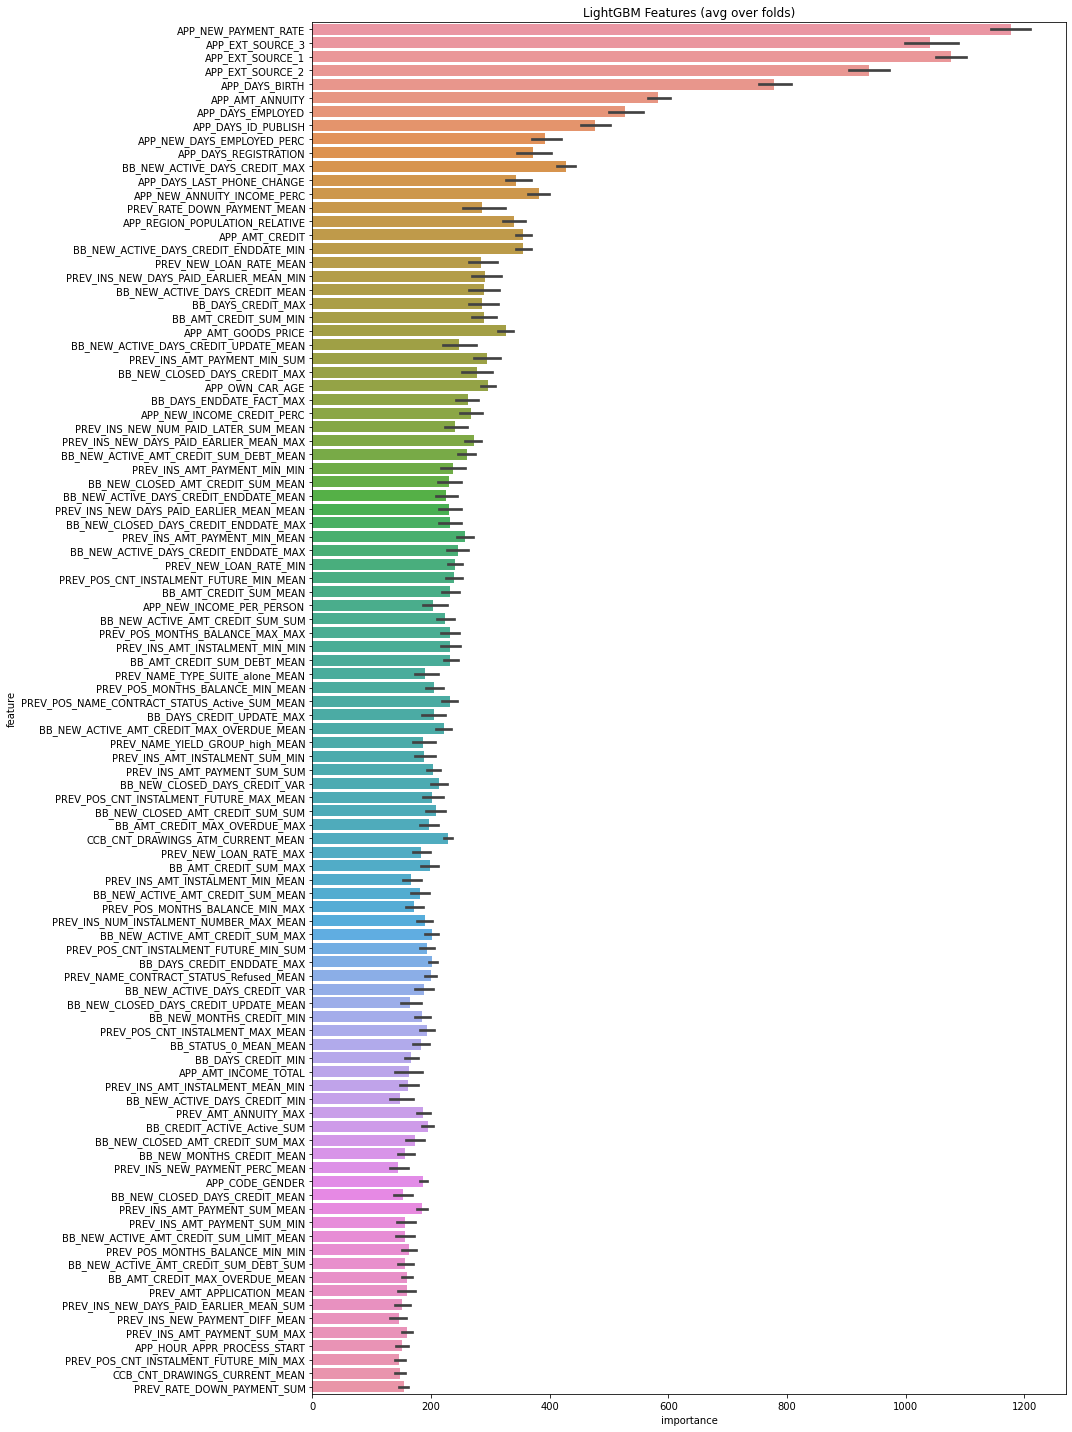

In [16]:
if __name__ == "__main__":
    with timer("Full model run"):
        main()